## Imports

In [1]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize, basinhopping
import optuna
import os
from pathlib import Path
import skvideo.io
import IPython

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
import numpy as np
def fig2np(fig):
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    return np.array(canvas.buffer_rgba())

%matplotlib inline

/home/daniel/anaconda3/envs/mthesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data (of a single time slice)

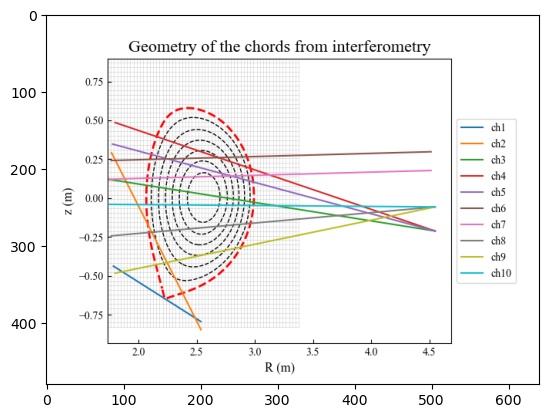

In [2]:
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

# plot_geometry_with_mag_equi(geo, equi)
fig = plot_geometry_with_mag_equi(geo, equi);
im = fig2np(fig)
plt.imshow(im)


In [ ]:
#make video cell
im = fig2np(fig)
all_frames = []
fps=20
t_range = np.arange(0,2,0.01)

for t in tqdm(t_range,desc='Generating Frames'):
    equi = equi_all.get_single_point(t)
    fig = plot_geometry_with_mag_equi(geo, equi)
    all_frames.append(fig2np(fig))

def write_video(frames, video_dir, video_filename, fps):
    print('write video on')
    frame_width = frames[0].shape[1]
    frame_height = frames[0].shape[0]
    path = os.path.join(video_dir,video_filename)
    print('path,',path)
    rate=str(fps)
    vid_out = skvideo.io.FFmpegWriter(path,outputdict={'-r': rate}, inputdict={'-r': rate})
    for im in frames:
        vid_out.writeFrame(im)
    vid_out.close()

write_video(all_frames,Path('videos'),'magflux.mp4',fps)
    
IPython.display.Video(Path('videos','magflux.mp4'))

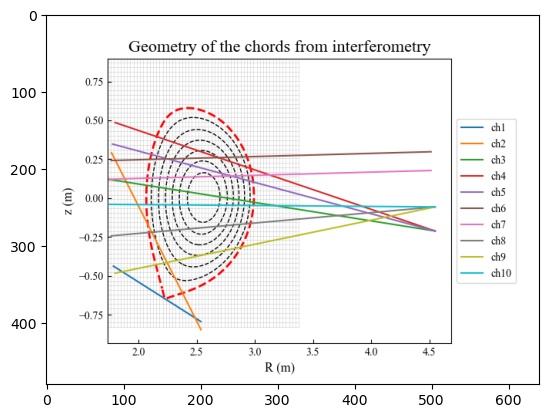

In [3]:
equi = equi_all.get_single_point(t)
fig = plot_geometry_with_mag_equi(geo, equi);
im = fig2np(fig)
plt.imshow(im)


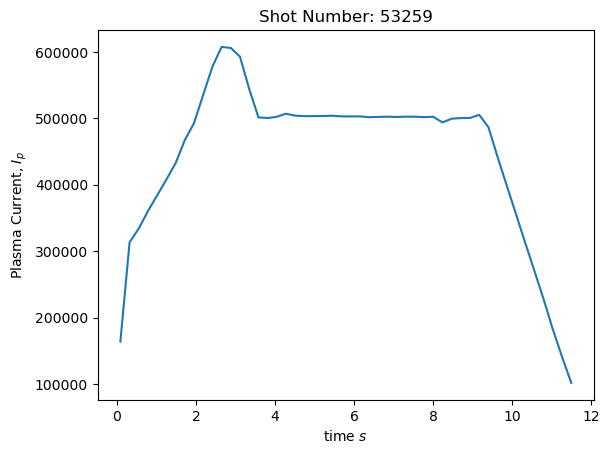

In [3]:
shot = 53259 # Shot number
plt.plot(equi_all.time_equi,equi_all.ip)
plt.title('Shot Number: '+str(shot))
plt.ylabel(r'Plasma Current, $I_p$')
plt.xlabel(r'time $s$')
plt.show()

In [17]:
lid_data = interf.lid.compressed()
print(lid_data)

[0.16766367 0.7151926  2.87897455 1.81505105 2.37688621 1.99854461
 2.56987925 2.57123607 1.67465628 2.87430901]




Not good if zero, as need to be chol_inverted.
The Determinent of K is: 0.0
The Determinent of cov_li is: 2.43e-08
The Determinent of cov_post3 is: 0.0


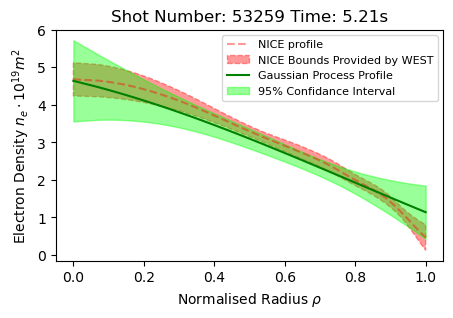

In [6]:
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))
##Prior
# intrinsic noise with no plasma 3e17 m-2
exp_er = 0.03 #*10^19 m^2
rho_1d = dens_prof.rho_tor_norm_1d
N = len(rho_1d)
mu_prior = np.zeros(N)
lid_data = interf.lid.compressed()
#exponential square kernel
def Kernel(rho1,rho2,params):
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((rho1-rho2)*(rho1-rho2))/(2*l**2))

def KRcov_li(params,trial_exp_er):
    rho1, rho2 = np.meshgrid(rho_1d,rho_1d)
    #covergence matrix of Prior
    K = Kernel(rho1,rho2,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_exp_er,10))
    R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li + R @ K @ R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
    return 0.5*np.log(chol_det(invertable)) + 0.5*(lid_data.T@chol_inv(invertable)@lid_data)                
    
# x0=[0.76,0.1]

x0=[5.62,1.37]
# results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=50)
# print(results)
# best_params = results.x
best_params = x0

def PlotBest(params,trial_exp_er): 
    K, R, cov_li = KRcov_li(params,trial_exp_er)
#     print(K)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (lid_data - R @ mu_prior)
    error_bars3 = 1.96*np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be chol_inverted.')
    print('The Determinent of K is:', chol_det(K))
    print('The Determinent of cov_li is:', chol_det(cov_li))
    print('The Determinent of cov_post3 is:', chol_det(cov_post3))

    figGPR3 = plt.figure(figsize=(5,3))
    plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
    plt.xlabel(r'Normalised Radius $\rho$')
    plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^2$')
    plt.plot(rho_1d, dens_prof.dens_1d,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
    plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
    plt.plot(rho_1d, mu_post3,'g', label='Gaussian Process Profile')
    plt.fill_between(rho_1d, mu_post3-error_bars3, mu_post3+error_bars3, color=(0,1,0,0.4),linestyle='-',label='95% Confidance Interval')
    # plt.errorbar(rho_1d, mu_post3, yerr=error_bars3, label='95% Confidance Interval of Inference', fmt='none')
    plt.legend(fontsize = 8)
    plt.show()

PlotBest(best_params, exp_er)

In [ ]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 10)
    l = trial.suggest_float('l', 0, 0.2)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

## Validation of the forward model

In [ ]:
# The response matrix used for calculating line integrals
response = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)



# Calculate the line integrated density using density profile fitted by NICE
lid_calculated = response @ dens_prof.dens_1d

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='measured')
ax2.plot(interf.channels.compressed(), lid_calculated, label='calculated')
ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()